## Long-Short-Term-Memory (LSTM) Recurrent Neural Networks (RNN)
##### For predicting shuttlecock trajectory
LSTM is a type of Recurrent Neural Networks (RNN) designed to handle sequential data by learning long-term dependencies such as time sequences. Unlike traditional RNNs, which suffer from the vanishing gradient problem, LSTMs use special memory cells and gates to selectively retain and forget information over long sequences. 

It is used as one of the neural network models to predict a shuttlecock's position of various sequences within an observation group
### Dependencies for LSTM RNN

In [1]:
# Data handling
import pandas as pd
import numpy as np
# LSTM RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
# Visualisations
import matplotlib.pyplot as plt

### Preparing Data for LSTM RNN (Normal)
Data was prepared for the LSTM model, following four main operations
- Angle convertion. For greater numeric stability angles were converted from degrees to radian. 
- Observation group train-test splitting. Due to LSTM's dependence on sequential dependencies, data was split randomly by observation groups numbers instead of individual rows to maintain these dependencies
- Normalising data. Independent and dependent feature values were both normalised from a scale of 0 to 1, allowing the LSTM model to converge faster and achieve greater numeric stability. 
- Reshaping for LSTM input. To meet LSTM's input requirement (samples, time steps per iteration, number of features), each independent feature record had to be reshaped. 

!!! To be fixed, spacing between 'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)'

Standardise to Space between brackets so SIDELINE (DEGREE)

In [24]:
def load_and_split_data_lstm(filepath):
    """Reusable function to load, normalise, and split data for LSTM RNN model."""
    data = pd.read_csv(filepath)
    # Convert angles to one of a continuous scale (radian)
    data['INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)'] = np.radians(data['INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)'])
    data['INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = np.radians(data['INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)'])
    # Rename columns
    data = data.rename(columns={
        'INITIAL SHUTTLECOCK FIRING ANGLE(DEGREE)': 'INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN)',
        'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(DEGREE)': 'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN)'})
    
    # Get unique numbers of observation groups
    observation_grps = data['OBSERVATION GROUP NUMBER'].unique()
    # Split observations groups into train-test sets, 80-20
    train_grps, test_grps = train_test_split(observation_grps, test_size=0.2, random_state=42)
    train_data = data[data['OBSERVATION GROUP NUMBER'].isin(train_grps)]
    test_data = data[data['OBSERVATION GROUP NUMBER'].isin(test_grps)]
    # Select features (X) and target variables (Y)
    x_columns = ['HUMAN PLAYER POSITION(X) metres',
        'HUMAN PLAYER POSITION(Y) metres',
        'HUMAN PLAYER POSITION(Z) metres',
        'OBSERVATION NUMBER', 
        'INITIAL VELOCITY OF SHUTTLECOCK(m/s)',
        'INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN)', 
        'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN)']
    y_columns = ['SHUTTLECOCK POSITION IN AIR(X) metres', 
        'SHUTTLECOCK POSITION IN AIR(Y) metres', 
        'SHUTTLECOCK POSITION IN AIR(Z) metres']
    x_train, x_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    # Initialize MinMaxScaler
    scaler_X, scaler_Y = MinMaxScaler(), MinMaxScaler()
    
    # Normalize X and Y
    X_train_scaled, X_test_scaled = scaler_X.fit_transform(x_train), scaler_X.transform(x_test)
    Y_train_scaled, Y_test_scaled = scaler_Y.fit_transform(y_train), scaler_Y.transform(y_test)

    # Reshaping training data to fit LSTM input requirement (samples, time_steps, features)
    X_train_scaled_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Print Dataset Summary
    print(f"Data Loaded & Processed\n"
          f"Total observation groups: {len(observation_grps)}\n"
          f"Training groups: {len(train_grps)}, Testing groups: {len(test_grps)}\n"
          f"Training samples: {X_train_scaled_reshaped.shape[0]}, Testing samples: {X_test_scaled_reshaped.shape[0]}\n"
          f"X Features: {X_train_scaled_reshaped.shape[2]}, Y Features: {Y_train_scaled.shape[1]}\n")

    return X_train_scaled_reshaped, X_test_scaled_reshaped, Y_train_scaled, Y_test_scaled, scaler_X, scaler_Y

In [25]:
normal_data_fp = "../../data/cleaned/normal_data.csv"
x_train_scaled_reshaped_normal, x_test_scaled_reshaped_normal, y_train_scaled_normal, y_test_scaled_normal, scaler_x_normal, scaler_y_normal = load_and_split_data_lstm(normal_data_fp)

Data Loaded & Processed
Total observation groups: 1576
Training groups: 1260, Testing groups: 316
Training samples: 134149, Testing samples: 34693
X Features: 7, Y Features: 3



### Optimising Hyperparameters of LSTM RNN (Normal)
These three hyperparameters are optimised during the tuning. 
- LSTM Units 1 - Neurons used for LSTM Layer 1
- LSTM Units 2 - Neurons used for LSTM Layer 2
- Batch sizing

For each tuning iteration, different combinations of LSTM units for both layers and batch sizes are experimented with, while storing the mean squared error, mean absolute error, and root mean squared error metrics for evaluations. 

In [4]:
def build_lstm_model(lstm_units_1, lstm_units_2, input_shape):
    """Reusable function to build LSTM RNN model with varying units for layer 1 and 2."""
    model = Sequential()
    # Builds LSTM RNN with two main layers, with varying units for layer 1 and 2
    model.add(LSTM(units=lstm_units_1, activation='tanh', return_sequences=True, input_shape=input_shape))      # First LSTM Layer
    model.add(LSTM(units=lstm_units_2, activation='tanh'))                                                      # Second LSTM Layer
    model.add(Dense(3, activation='linear'))                                                                    # Activation layer, to predict X, Y, Z positions
    # Compile and return model
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, batch_size):
    """Reusable function to train and evaluate LSTM RNN model with varying batch sizes."""
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    # Train model using varying batch size and early stopping if performance does not improve
    model.fit(x_train, y_train, epochs=50, batch_size = batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    # Evaluate the model
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}

def hyperparameter_tuning_lstm(x_train, y_train, x_test, y_test, lstm_unit_1_list, lstm_unit_2_list, batch_size_list):
    """Main function to perform hyperparameter tuning for different LSTM configurations."""
    results = []
    # Iterate through different LSTM units and batch sizes
    for lstm_units_1 in lstm_unit_1_list:
        for lstm_units_2 in lstm_unit_2_list:
            for batch_size in batch_size_list:
                print(f"\n🔹 Training: Layer 1 = {lstm_units_1} units, Layer 2 = {lstm_units_2} units, Batch Size = {batch_size}")

                # Build Model
                model = build_lstm_model(lstm_units_1, lstm_units_2, (None, x_train.shape[2]))
                # Train and Evaluate
                metrics = train_and_evaluate_model(model, x_train, y_train, x_test, y_test, batch_size)
                # Store results
                results.append({'LSTM Units (Layer 1)': lstm_units_1, 'LSTM Units (Layer 2)': lstm_units_2, 'Batch Size': batch_size, **metrics})

                print(f"✅ Completed: MAE={metrics['MAE']:.5f}, MSE={metrics['MSE']:.5f}, RMSE={metrics['RMSE']:.5f}")

    results_df = pd.DataFrame(results)
    return results_df

Batch sizes of 16, 32, 64 are experimented with. Neuron sizes of 64, 128, 256 are experimented with for the first layer, followed by 32, 64, 128 for the second layer. 

In [11]:
lstm_unit_1_list = [64, 128, 256]
lstm_unit_2_list = [32, 64, 128]
batch_size_list=[16, 32, 64]

In [ ]:
hyperparameter_results_normal = hyperparameter_tuning_lstm(x_train_scaled_reshaped_normal, y_train_scaled_normal, x_test_scaled_reshaped_normal, y_test_scaled_normal, lstm_unit_1_list, lstm_unit_2_list, batch_size_list)


🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
✅ Completed: MAE=0.00432, MSE=0.00006, RMSE=0.00765

🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step
✅ Completed: MAE=0.00323, MSE=0.00005, RMSE=0.00733

🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 445us/step
✅ Completed: MAE=0.00439, MSE=0.00012, RMSE=0.01114

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step
✅ Completed: MAE=0.00130, MSE=0.00002, RMSE=0.00471

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
✅ Completed: MAE=0.00443, MSE=0.00008, RMSE=0.00882

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step
✅ Completed: MAE=0.00234, MSE=0.00004, RMSE=0.00625

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step
✅ Completed: MAE=0.00275, MSE=0.00003, RMSE=0.00540

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step
✅ Completed: MAE=0.00180, MSE=0.00002, RMSE=0.00391

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step
✅ Completed: MAE=0.00445, MSE=0.00008, RMSE=0.00901

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step
✅ Completed: MAE=0.00357, MSE=0.00003, RMSE=0.00528

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step
✅ Completed: MAE=0.00197, MSE=0.00003, RMSE=0.00512

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step
✅ Completed: MAE=0.00360, MSE=0.00006, RMSE=0.00777

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step
✅ Completed: MAE=0.00221, MSE=0.00003, RMSE=0.00590

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step
✅ Completed: MAE=0.00186, MSE=0.00001, RMSE=0.00382

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step
✅ Completed: MAE=0.00266, MSE=0.00004, RMSE=0.00594

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step
✅ Completed: MAE=0.00387, MSE=0.00005, RMSE=0.00707

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step
✅ Completed: MAE=0.00123, MSE=0.00001, RMSE=0.00324

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step
✅ Completed: MAE=0.00136, MSE=0.00002, RMSE=0.00390

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step
✅ Completed: MAE=0.00208, MSE=0.00002, RMSE=0.00495

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
✅ Completed: MAE=0.00228, MSE=0.00005, RMSE=0.00675

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
✅ Completed: MAE=0.00325, MSE=0.00009, RMSE=0.00961

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step
✅ Completed: MAE=0.00275, MSE=0.00006, RMSE=0.00779

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step
✅ Completed: MAE=0.00181, MSE=0.00003, RMSE=0.00531

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step
✅ Completed: MAE=0.00277, MSE=0.00004, RMSE=0.00592

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step
✅ Completed: MAE=0.00201, MSE=0.00002, RMSE=0.00497

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
✅ Completed: MAE=0.00298, MSE=0.00005, RMSE=0.00722

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step
✅ Completed: MAE=0.00159, MSE=0.00002, RMSE=0.00389


In [13]:
def plot_lstm_results(results_df):
    """Plot the performance of different LSTM hyperparameters with consistent Y-axis and side-by-side subplots."""
    # Get unique values for LSTM Units (Layer 2) to create subplots
    lstm_units_2_values = results_df['LSTM Units (Layer 2)'].unique()
    num_plots = len(lstm_units_2_values)
    # Determine Y-axis limits for consistent scaling
    y_min = results_df['MSE'].min()
    y_max = results_df['MSE'].max()
    # Create side-by-side subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    # If only one plot, make sure axes is iterable
    if num_plots == 1:
        axes = [axes]
    # Plot each subplot
    for i, lstm_units_2 in enumerate(lstm_units_2_values):
        ax = axes[i]
        subset_layer2 = results_df[results_df['LSTM Units (Layer 2)'] == lstm_units_2]
        # Plot each batch size on the same subplot
        for batch_size in subset_layer2['Batch Size'].unique():
            subset = subset_layer2[subset_layer2['Batch Size'] == batch_size]
            ax.plot(subset['LSTM Units (Layer 1)'], subset['MSE'], marker='o', label=f'Batch {batch_size}')
        # Add plot labels and title
        ax.set_xlabel("LSTM Units (Layer 1)")
        ax.set_ylabel("Mean Squared Error (MSE)")
        ax.set_title(f"LSTM Performance (Layer 2 = {lstm_units_2} units)")
        ax.legend()
        ax.grid()
        ax.set_ylim(y_min, y_max)  # Set the same Y-axis range across plots

    plt.tight_layout()
    plt.show()

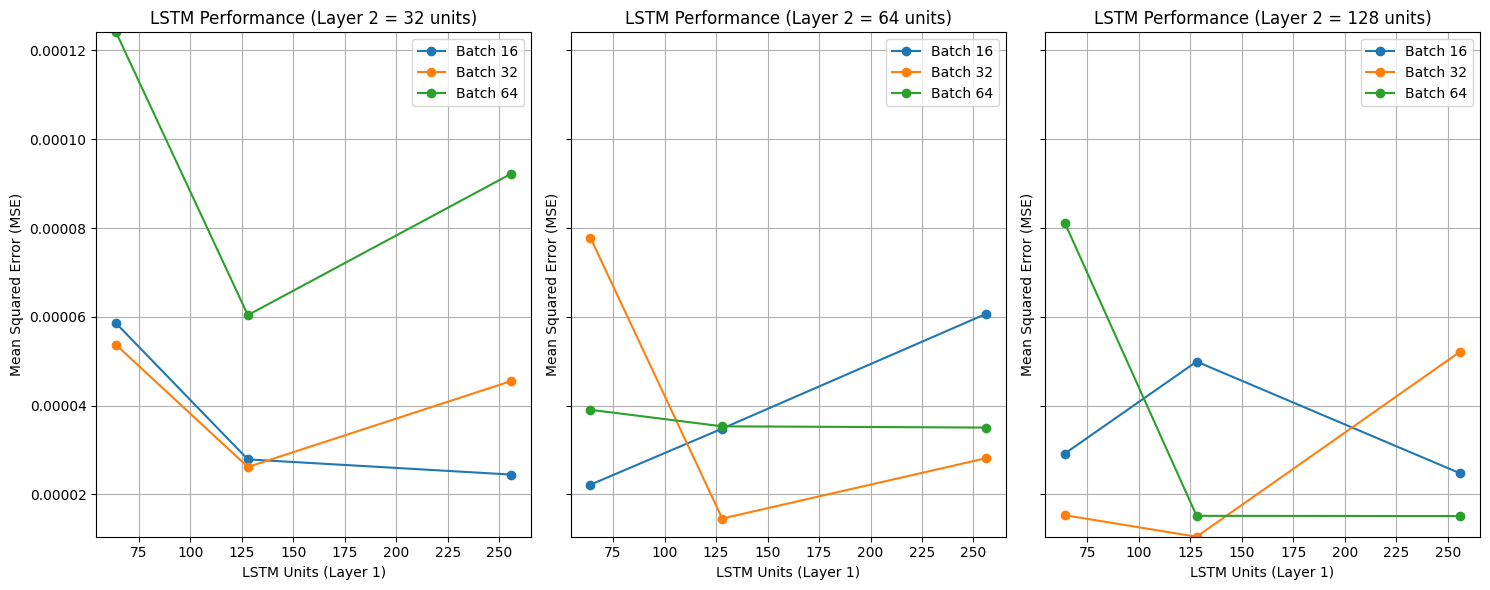

In [14]:
plot_lstm_results(hyperparameter_results_normal)

From this diagram, it is observed that the optimal hyperparameters are 128, 128, 3 for the normal LSTM RNN model, with a batch size of 32 achieving a mean squared error of 0.00001

### Preparing Data for LSTM RNN (Limited)
Same procedures as earlier, with datasets of limited and derived features

In [15]:
limited_data_fp = "../../data/cleaned/limited_data.csv"
x_train_scaled_limited, x_test_scaled_limited, y_train_scaled_limited, y_test_scaled_limited, scaler_x_limited, scaler_y_limited = load_and_split_data_lstm(limited_data_fp)

Data Loaded & Processed
Total observation groups: 1576
Training groups: 1260, Testing groups: 316
Training samples: 134149, Testing samples: 34693
X Features: 7, Y Features: 3



### Optimising Hyperparameters for LSTM RNN (Limited)
Reusing same batch sizes, lstm units lists for layer 1 and 2, with the dataset of limited and derived features

In [16]:
hyperparameter_results_limited = hyperparameter_tuning_lstm(x_train_scaled_limited, y_train_scaled_limited, x_test_scaled_limited, y_test_scaled_limited, lstm_unit_1_list, lstm_unit_2_list, batch_size_list)


🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step
✅ Completed: MAE=0.00160, MSE=0.00002, RMSE=0.00423

🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
✅ Completed: MAE=0.00180, MSE=0.00004, RMSE=0.00604

🔹 Training: Layer 1 = 64 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
✅ Completed: MAE=0.00266, MSE=0.00004, RMSE=0.00603

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
✅ Completed: MAE=0.00370, MSE=0.00008, RMSE=0.00913

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step
✅ Completed: MAE=0.00277, MSE=0.00005, RMSE=0.00692

🔹 Training: Layer 1 = 64 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step
✅ Completed: MAE=0.00250, MSE=0.00003, RMSE=0.00505

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step
✅ Completed: MAE=0.00104, MSE=0.00001, RMSE=0.00346

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step
✅ Completed: MAE=0.00368, MSE=0.00005, RMSE=0.00682

🔹 Training: Layer 1 = 64 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step
✅ Completed: MAE=0.00306, MSE=0.00008, RMSE=0.00869

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step
✅ Completed: MAE=0.00263, MSE=0.00005, RMSE=0.00727

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step
✅ Completed: MAE=0.00144, MSE=0.00001, RMSE=0.00371

🔹 Training: Layer 1 = 128 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step
✅ Completed: MAE=0.00240, MSE=0.00003, RMSE=0.00535

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step
✅ Completed: MAE=0.00138, MSE=0.00001, RMSE=0.00354

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step
✅ Completed: MAE=0.00210, MSE=0.00003, RMSE=0.00558

🔹 Training: Layer 1 = 128 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step
✅ Completed: MAE=0.00207, MSE=0.00002, RMSE=0.00445

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step
✅ Completed: MAE=0.00179, MSE=0.00002, RMSE=0.00474

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step
✅ Completed: MAE=0.00199, MSE=0.00002, RMSE=0.00440

🔹 Training: Layer 1 = 128 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step
✅ Completed: MAE=0.00228, MSE=0.00003, RMSE=0.00536

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step
✅ Completed: MAE=0.00128, MSE=0.00002, RMSE=0.00392

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step
✅ Completed: MAE=0.00183, MSE=0.00002, RMSE=0.00404

🔹 Training: Layer 1 = 256 units, Layer 2 = 32 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
✅ Completed: MAE=0.00301, MSE=0.00003, RMSE=0.00538

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step
✅ Completed: MAE=0.00155, MSE=0.00003, RMSE=0.00517

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step
✅ Completed: MAE=0.00374, MSE=0.00007, RMSE=0.00810

🔹 Training: Layer 1 = 256 units, Layer 2 = 64 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step
✅ Completed: MAE=0.00259, MSE=0.00003, RMSE=0.00521

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 16


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
✅ Completed: MAE=0.00199, MSE=0.00002, RMSE=0.00420

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 32


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step
✅ Completed: MAE=0.00332, MSE=0.00004, RMSE=0.00599

🔹 Training: Layer 1 = 256 units, Layer 2 = 128 units, Batch Size = 64


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1085/1085 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step
✅ Completed: MAE=0.00126, MSE=0.00001, RMSE=0.00261


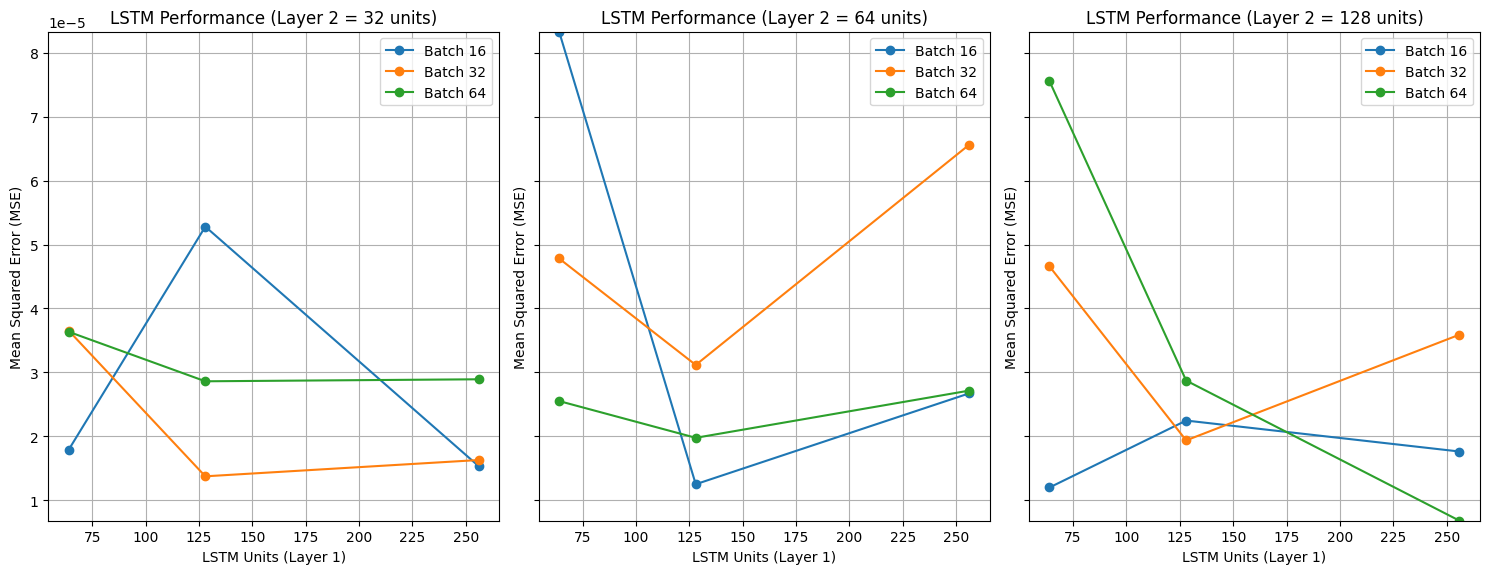

In [17]:
plot_lstm_results(hyperparameter_results_limited)

From this diagram, it is observed that the optimal hyperparameters are 256, 128, 3 for the normal LSTM RNN model, with a batch size of 64 achieving a mean squared error of 0.00001

### Optimising Feature Weightages
To explore the importance of features and how it will affect predictions, weightages of features will now be included and compared against performance of unweighted models.

In [26]:
# Combine x_train and x_test for PCA
x_scaled_normal = np.vstack([x_train_scaled_reshaped_normal.reshape(x_train_scaled_reshaped_normal.shape[0], x_train_scaled_reshaped_normal.shape[2]), 
    x_test_scaled_reshaped_normal.reshape(x_test_scaled_reshaped_normal.shape[0], x_test_scaled_reshaped_normal.shape[2])])
# Perform PCA
pca = PCA()
pca.fit(x_scaled_normal)
# Calculate relative contribution of each feature to total weightages
absolute_loadings = np.abs(pca.components_)
total_loadings = np.sum(absolute_loadings, axis=0)
relative_contribution = total_loadings / np.sum(total_loadings)
# Define original independent features
feature_names = ['HUMAN PLAYER POSITION(X) metres',
        'HUMAN PLAYER POSITION(Y) metres',
        'HUMAN PLAYER POSITION(Z) metres',
        'OBSERVATION NUMBER', 
        'INITIAL VELOCITY OF SHUTTLECOCK(m/s)',
        'INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN)', 
        'INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN)']
# Sort the features based on their relative contribution, stores original index
sorted_features = np.argsort(relative_contribution)[::-1]
# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_names[feature_idx]}: Significance = {relative_contribution[feature_idx]}")

Feature INITIAL SHUTTLECOCK FIRING ANGLE(RADIAN): Significance = 0.1753064205185976
Feature INITIAL VELOCITY OF SHUTTLECOCK(m/s): Significance = 0.17435125899613987
Feature HUMAN PLAYER POSITION(Z) metres: Significance = 0.16320660282403177
Feature OBSERVATION NUMBER: Significance = 0.1585371564558181
Feature HUMAN PLAYER POSITION(Y) metres: Significance = 0.12108772464048136
Feature INITIAL SHUTTLECOCK SLANT ANGLE TO SIDELINE(RADIAN): Significance = 0.11750121572065625
Feature HUMAN PLAYER POSITION(X) metres: Significance = 0.09000962084427515


In [ ]:
# Apply feature weightages to dataset
x_train_scaled_reshaped_weighted_normal = x_train_scaled_reshaped_normal * relative_contribution
x_test_scaled_reshaped_weighted_normal = x_test_scaled_reshaped_normal * relative_contribution
# Build a LSTM model with weighted features and optimal hyperparameters
lstm_weighted = build_lstm_model(128, 128, (None, x_train_scaled_reshaped_weighted_normal.shape[2]))
weighted_metrics = train_and_evaluate_model(lstm_weighted, x_train_scaled_reshaped_weighted_normal, y_train_scaled_normal, x_test_scaled_reshaped_weighted_normal, y_test_scaled_normal, 32)
# Build a LSTM model with non-weighted features and optimal hyperparameters
lstm_nonweighted = build_lstm_model(128, 128, (None, x_train_scaled_reshaped_normal.shape[2]))
non_weighted_metrics = train_and_evaluate_model(lstm_nonweighted, x_train_scaled_reshaped_normal, y_train_scaled_normal, x_test_scaled_reshaped_normal, y_test_scaled_normal, 32)


c:\Users\mattz\Documents\Github\CSC3005-Shuttlecock-Trajectory-Estimation\dependencies\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Plot comparison
def plot_comparison(weighted_metrics, non_weighted_metrics):
    """
    Plot the performance comparison between weighted and non-weighted features.
    """
    metrics = ["MAE", "MSE", "RMSE"]
    weighted_vals = [weighted_metrics[metric] for metric in metrics]
    non_weighted_vals = [non_weighted_metrics[metric] for metric in metrics]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, weighted_vals, alpha=0.7, label="Weighted Features")
    plt.bar(metrics, non_weighted_vals, alpha=0.7, label="Non-Weighted Features")
    plt.xlabel("Metric")
    plt.ylabel("Error Value")
    plt.title("LSTM Model Performance: Weighted vs Non-Weighted Features")
    plt.legend()
    plt.show()

print(f"Weighted Features: MAE={weighted_metrics['MAE']:.5f}, MSE={weighted_metrics['MSE']:.5f}, RMSE={weighted_metrics['RMSE']:.5f}")
print(f"Non-Weighted Features: MAE={non_weighted_metrics['MAE']:.5f}, MSE={non_weighted_metrics['MSE']:.5f}, RMSE={non_weighted_metrics['RMSE']:.5f}")
plot_comparison(weighted_metrics, non_weighted_metrics)

In [ ]:
# import plotly.graph_objects as go

# y_pred_original = scaler_Y.inverse_transform(y_pred)
# y_test_original = scaler_Y.inverse_transform(y_test_scaled_limited)

# # Create the 3D scatter plot
# fig = go.Figure(data=[
#     go.Scatter3d(
#         x=y_test_original[:, 0],  # X-coordinate of the true values
#         y=y_test_original[:, 1],  # Y-coordinate of the true values
#         z=y_test_original[:, 2],  # Z-coordinate of the true values
#         mode='markers',
#         name='True Values',
#         marker=dict(color='blue', size=2),
#         opacity=0.7
#     ),
#     go.Scatter3d(
#         x=y_pred_original[:, 0],  # X-coordinate of the predicted values
#         y=y_pred_original[:, 1],  # Y-coordinate of the predicted values
#         z=y_pred_original[:, 2],  # Z-coordinate of the predicted values
#         mode='markers',
#         name='Predicted Values',
#         marker=dict(color='red', size=2),
#         opacity=0.7
#     )
# ])

# # Set plot title anz`d axis labels
# fig.update_layout(
#     title='True Values vs Predicted Values',
#     scene=dict(
#         xaxis_title='X-coordinate',
#         yaxis_title='Y-coordinate',
#         zaxis_title='Z-coordinate'
#     )
# )

# # Show the 3D plot
# fig.show()
